<a href="https://colab.research.google.com/github/dileep9968/pytorch/blob/main/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Get setup

In [1]:
import torch
import torchvision

In [2]:
try:
  from torchinfo import summary

except:
  print("[INFO] couldn't find torchinfo, installing it...")
  !pip install torchinfo
  from torchinfo import summary

try:
  from going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  print("[INFO] couldn't find going_modular, installing it...")
  !git clone https://github.com/dileep9968/pytorch
  !mv pytorch/going_modular .
  !mv pytorch/helper_functions.py .
  !rm -rf pytorch
  from going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] couldn't find torchinfo, installing it...
[INFO] couldn't find going_modular, installing it...
Cloning into 'pytorch'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 84 (delta 35), reused 10 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (84/84), 11.70 MiB | 8.93 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [3]:
!ls going_modular

data_setup.py  model_builder.py  __pycache__  train.py
engine.py      predictions.py	 README.md    utils.py


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Getting data

In [5]:
# Download pizz, steak, sushu images form github

data_20_percent_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip',
                                     destination = 'pizza_steak_sushi_20_percent')

data_20_percent_path


[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [6]:
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini Model deployment experiment outline

## #. Creating an effnetb2 features extractor

In [7]:
#effnetb2

In [8]:
# from torchinfo import summary
# summary(model =effnetb2,
#         input_size = (1,3,224,224),
#         col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
#         col_width=20,
#         row_settings = ['var_names'])

In [9]:
### 3.1 Creating a function to make an EffnetB2 features extractor
from torch import nn
def create_effnetb2_model(num_classes:int = 3,
                          seed:int = 42,
                          ):
  set_seeds(seed = seed)
  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  effnetb2_transforms = effnetb2_weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = effnetb2_weights)
  for param in model.parameters():
    param.requires_grad = False


  set_seeds()
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes, bias=True)
  )
  return model, effnetb2_transforms

In [10]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42
                                                      )



Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 74.3MB/s]


### 3.2 Create DAtaloader for EffNetB2

In [11]:
# Setup DataLoaders

from going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = effnetb2_transforms,
    batch_size = 32
)

In [12]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [16]:
### 3.3 Training EffNetB2 features extractor
from going_modular import engine
import os


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = effnetb2.parameters(),
                             lr = 0.001)

set_seeds()
effnetb2_results = engine.train(model = effnetb2,
                            train_dataloader = train_dataloader_effnetb2,
                            test_dataloader = test_dataloader_effnetb2,
                            loss_fn = loss_fn,
                            optimizer = optimizer,
                            epochs = 10,
                            device = device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3480 | train_acc: 0.9146 | test_loss: 0.3351 | test_acc: 0.9688
Epoch: 2 | train_loss: 0.3169 | train_acc: 0.9208 | test_loss: 0.3150 | test_acc: 0.9443
Epoch: 3 | train_loss: 0.2944 | train_acc: 0.9375 | test_loss: 0.2802 | test_acc: 0.9750
Epoch: 4 | train_loss: 0.2422 | train_acc: 0.9437 | test_loss: 0.2724 | test_acc: 0.9625
Epoch: 5 | train_loss: 0.2524 | train_acc: 0.9292 | test_loss: 0.2596 | test_acc: 0.9381
Epoch: 6 | train_loss: 0.3287 | train_acc: 0.9167 | test_loss: 0.2421 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.3185 | train_acc: 0.9042 | test_loss: 0.2329 | test_acc: 0.9625
Epoch: 8 | train_loss: 0.3056 | train_acc: 0.9208 | test_loss: 0.2709 | test_acc: 0.9381
Epoch: 9 | train_loss: 0.3248 | train_acc: 0.9125 | test_loss: 0.2447 | test_acc: 0.9256
Epoch: 10 | train_loss: 0.2815 | train_acc: 0.8792 | test_loss: 0.2142 | test_acc: 0.9563


### 3.4 Inspection loss

In [17]:
from helper_functions import plot_loss_curves


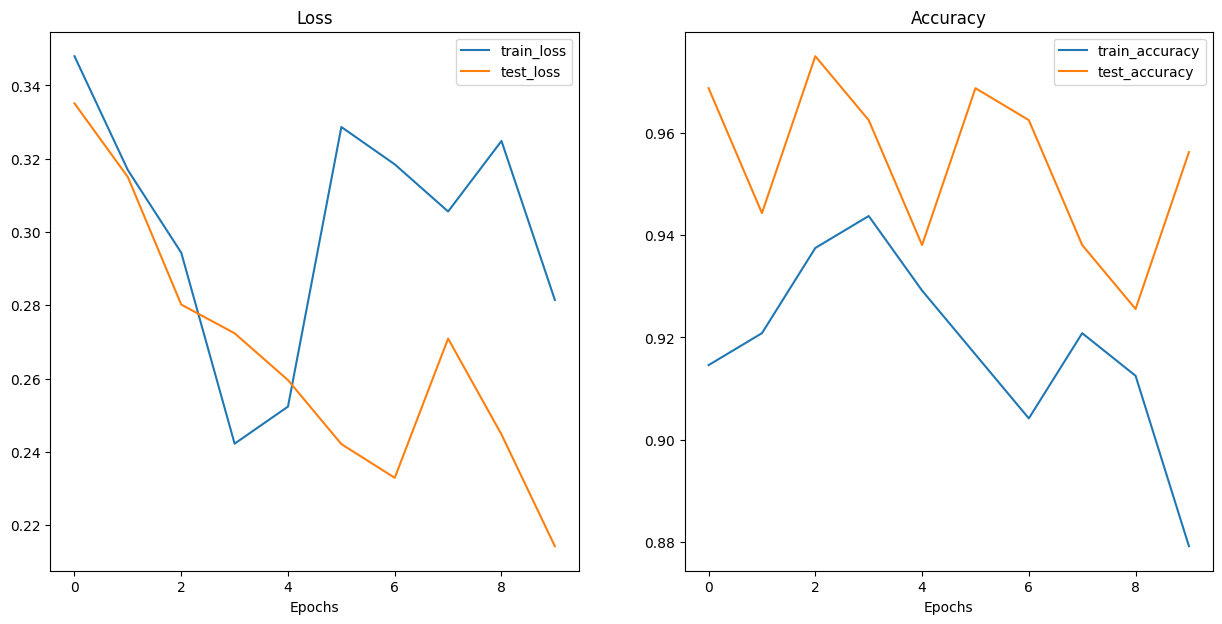

In [18]:
plot_loss_curves(effnetb2_results)

### 3.5 Saving EffnetB2 Features extractor

In [19]:
from going_modular import utils

# saving the model
utils.save_model(model = effnetb2,
                 target_dir = 'models',
                 model_name = '09_pretrained_effnetb2_features_extractor_pizza_steak_20_percent.pth')


[INFO] Saving model to: models/09_pretrained_effnetb2_features_extractor_pizza_steak_20_percent.pth


### e.6 Inspection the size of our effnetb2 features extractor

In [20]:
from pathlib import Path

# GEt the model size in bytes

pretrained_effnetb2_model_size = Path('models/09_pretrained_effnetb2_features_extractor_pizza_steak_20_percent.pth').stat().st_size//(1024*1024)

print(f"Pretrained EffNetB2 model size: {pretrained_effnetb2_model_size} MB")


Pretrained EffNetB2 model size: 29 MB


### 3.7 Collect Effnetb2 featues extractor stats


In [21]:
# count nuber of parameters in EffNetB2

effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [25]:
# Create a dictionary  with effnetb2  statistic

effnetb2_stats = {
    "test_loss":effnetb2_results['test_loss'][-1],
    "test_acc":effnetb2_results['test_acc'][-1],
    "model_params":effnetb2_total_params,
    "model_size (MB)": pretrained_effnetb2_model_size
}

In [26]:
effnetb2_stats

{'test_loss': 0.2142400026321411,
 'test_acc': 0.95625,
 'model_params': 7705221,
 'model_size (MB)': 29}

## 4. Creating a VIT Features Extractor

In [29]:
vit = torchvision.models.vit_b_16()

vit.heads


Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [30]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  set_seeds()
  model.heads = nn.Sequential(
      nn.Linear(in_features=768, out_features=num_classes, bias=True)
  )
  return model, transforms

In [31]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 53.2MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### 4.1 Create DataLoader for ViT features extractor


In [33]:
from going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = vit_transforms,
    batch_size = 32
)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training Vit features extractor

In [34]:
from going_modular import engine

optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr = 1e-3)

loss_fn = nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model = vit,
                           train_dataloader = train_dataloader_vit,
                           test_dataloader = test_dataloader_vit,
                           loss_fn = loss_fn,
                           optimizer = optimizer,
                           epochs = 10,
                           device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Plot loss Curves of VIT Transforms

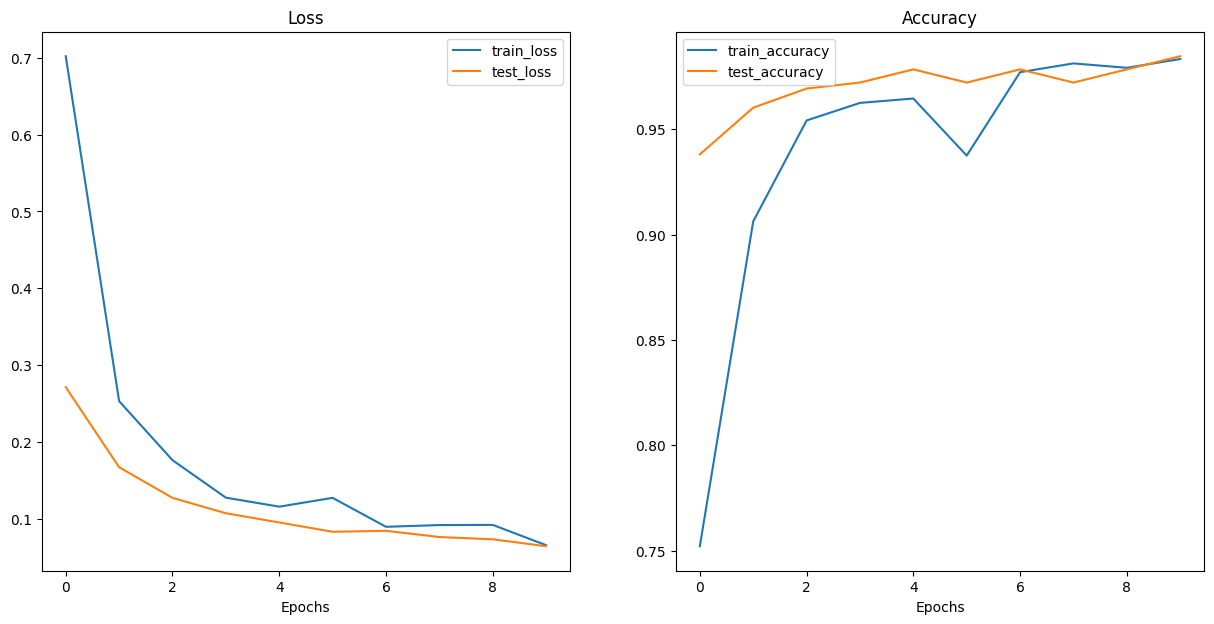

In [35]:
from helper_functions import plot_loss_curves
plot_loss_curves(vit_results)

### 4.4 Saving ViT features extractor

In [36]:
from going_modular import utils

utils.save_model(model = vit,
                 target_dir = 'models',
                 model_name = '09_pretrained_vit_features_extractor_pizza_steak_20_percent.pth')

[INFO] Saving model to: models/09_pretrained_vit_features_extractor_pizza_steak_20_percent.pth


### 4.5 Checking the size of ViT features extractor

In [37]:
from pathlib import Path

pretrained_vit_model_size = Path('models/09_pretrained_vit_features_extractor_pizza_steak_20_percent.pth').stat().st_size//(1024*1024)
print(f"Pretrained ViT model size: {pretrained_vit_model_size} MB")

Pretrained ViT model size: 327 MB


### 4.6 Collecting ViT features extractor

In [39]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [40]:
effnetb2_total_params

7705221

In [41]:
vit_stats = {
    "test_loss":vit_results['test_loss'][-1],
    "test_acc":vit_results['test_acc'][-1],
    "model_params":vit_total_params,
    "model_size (MB)": pretrained_vit_model_size
}
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'model_params': 85800963,
 'model_size (MB)': 327}

## 5. Making predictions with model trained model and timming them

In [42]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1523026.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2061929.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/86782.jpg')]

### 5.1 Creating a function to make across the test dataset


In [45]:
from typing import List, Dict
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm


def pred_and_store(
    paths: List[pathlib.Path],
    model: torch.nn.Module,
    transform: torchvision.transforms,
    class_names: List[str],
    device: str= 'cuda' if torch.cuda.is_available() else 'cpu'
) -> List[Dict]:
  pred_list = []

  # Loop through the target input path
  for path in tqdm(paths):

    # create an empty dictionary for each sample
    pred_dict = {}

    # set the sample path and ground truth class from the filepath
    pred_dict['image_path']=path
    class_name = path.parent.stem
    pred_dict['class_name']=class_name

    start_time = timer()

    # open the iamge using PIL
    img = Image.open(path)

    # transformxing the iamge
    transformed_image = transform(img).unsqueeze(0).to(device)

    # prepare the model for inference
    model = model.to(device)
    model.eval()

    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_dict['pred_class'] = class_names[pred_label.cpu()]  # python variable on cpu

      # add the pred + pred class to empty dictionary from step 4

      pred_dict['pred_prob']=round(pred_prob.unsqueeze(0).max().cpu().item(),4)
      end_time = timer()
      pred_dict['pred_time']=round(end_time-start_time,4)

    # see if th predicted class matches the ground truth class
    pred_dict['correct'] = pred_dict['pred_class'] == pred_dict['class_name']

    pred_list.append(pred_dict)
  return pred_list

### 5.2 Making and timing predction with EffNetB2

In [46]:
# Make predtions test dataset with effnetB2
effnetb2_test_pred_dict = pred_and_store(paths = test_data_paths,
                                         model=effnetb2,
                                         transform=effnetb2_transforms,
                                         class_names=class_names,
                                         device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [48]:
effnetb2_test_pred_dict[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.9809,
  'pred_time': 0.3351,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1523026.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.8227,
  'pred_time': 0.1366,
  'correct': True}]

In [49]:
# turn the test_pred_dict into dataframe
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dict)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_class,pred_prob,pred_time,correct
0,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,steak,0.9809,0.3351,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,steak,0.8227,0.1366,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,steak,0.9682,0.1512,True
3,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,steak,0.9612,0.1676,True
4,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,steak,0.8757,0.1264,True


In [50]:
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,143
False,7


In [52]:
# Find the av time per predition
effnetb2_avg_time_per_pred = round(effnetb2_test_pred_df.pred_time.mean(),4)
print(f"Effnet avergage time per prediction: {effnetb2_avg_time_per_pred}")

Effnet avergage time per prediction: 0.0964


### 5.3 Making and timing preditions with ViT


In [53]:
# Make list of prediction dictionaries with ViT features
vit_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                     model = vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [54]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.989,
  'pred_time': 0.5793,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1523026.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.9949,
  'pred_time': 0.4497,
  'correct': True}]

In [55]:
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_class,pred_prob,pred_time,correct
0,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,steak,0.9890,0.5793,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,steak,0.9949,0.4497,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,steak,0.9725,0.5291,True
3,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,steak,0.7962,0.5174,True
4,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,steak,0.9738,0.5164,True


In [57]:
vit_test_pred_df.correct.value_counts()

,count
correct,
True,148
False,2


In [58]:
# Calaculate avg time per predction for ViT model
vit_avg_time_per_pred = round(vit_test_pred_df.pred_time.mean(),4)
print(f"ViT avergage time per prediction: {vit_avg_time_per_pred}")

ViT avergage time per prediction: 0.4307
